---
---
### Definições importantes 


**Def. 1:**

``#### NLP``
>"O processamento de linguagem natural (NLP) é um ramo da inteligência artificial (IA) que permite aos computadores compreender, gerar e manipular a linguagem humana. O processamento de linguagem natural tem a capacidade de interrogar os dados com texto ou voz de linguagem natural." [Oracle](https://www.oracle.com/br/artificial-intelligence/what-is-natural-language-processing/#:~:text=O%20processamento%20de%20linguagem%20natural%20(NLP)%20%C3%A9%20um%20ramo%20da,ou%20voz%20de%20linguagem%20natural.)


**Def. 2:**

``#### Análise de Sentimentos``

>"Análise de sentimento, também conhecida como mineração de opinião, é o
campo de estudo que analisa as opiniões, sentimentos, avaliações, atitudes
e emoções das pessoas em relação a entidades como produtos, serviços,
organizações, indivíduos, eventos e seus aspectos" (LIU, 2012)

---


---
---
### Utilidades:

**[Ferramentas para Processamento de Linguagem Natural em Português](https://medium.com/turing-talks/ferramentas-para-processamento-de-linguagem-natural-em-portugu%C3%AAs-977c7f59c382)**
- Um guia para as principais bibliotecas para se trabalhar com NLP em português
---

---

O código utilizado tem como fonte principal a live _Live #6: Análise de Sentimentos Utilizando Dados do Twitter (Passo a passo)_ do canal Stack. O código sofreu modificações e adição de comentários conforme se julgou necessário para a melhor compreensão do conteúdo ou para testar coisas novas. Link da live abaixo:
- FONTE: https://www.youtube.com/watch?v=Zy5sHkr5W7s

---
---

## **Análise de Sentimentos usando Machine Learning**

* Criando modelos para análise de sentimentos de tweets

In [1]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

**Ler arquivo de dados e conta a quantidade de linhas**

Foram disponibilizados dados de tweets que foram coletados com base em alguns termos e palavras chaves de Minas Gerais (relacionados a dados públicos, política, educação, etc - base de dados cedida pela PRODEMGE.)

In [2]:
df = pd.read_csv('Tweets_Mg.csv', encoding='utf-8')

In [3]:
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


``No dataset há basicamente 3 colunas de interesse: o twitt (texto), o sentimento rotulado pela equipe e a data.``

**Conta a quantidade de linhas de tweets neutros, positivos e negativos**

O trabalho presente é multilabel (i.e., não é binário [positivo/negativo, por exemplo])

Distribuição é balanceada entre as classes!

In [4]:
df.Classificacao.value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

<AxesSubplot:>

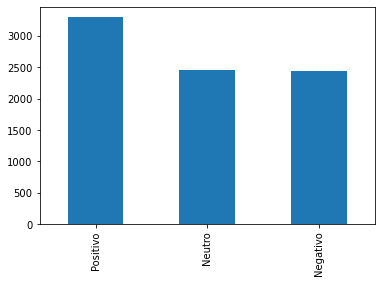

In [5]:
%matplotlib inline
df.Classificacao.value_counts().plot(kind='bar')

In [6]:
df.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

## Pre-Processamento dos Dados

Base apresenta um problema de dados com a coleta. Passo inicial é limpar a base. Por exemplo, pode haver tweets duplicados por causa dos re-tweets, que acaba mudando apenas um ponto, por exemplo, no dataset, mas que representa a mesma informação.

* Remove linhas duplicadas na base de dados
    - Problema na coleta dos dados.
* Remove Stopwords
* Stemming ou Lemmatization
* Remove caracteres indesejados como links etc.

In [7]:
df.drop_duplicates(['Text'], inplace=True)  # usando como referência para duplicatas a coluna texto, deixando as outras poderem variar livremente

In [8]:
df.Text.count() # com tratamento, fomos de 8199 tweets para 5765.O tratamento feito na live foi só de duplicatas, mas deixou destaque com os pontos acima de que há outros tratamentos desejáveis mas que fugiiam do foco da live

5765

## **Separando tweets e suas Classes**

Objetivo mencionado foi deixar mais claro o processo a ser apresentado.

In [9]:
tweets = df['Text']
classes = df['Classificacao']

**Instala bibliotecas e baixa a base de dados**

> NLTK significa Natural Language Toolkit, que é algo como uma caixa de ferramentas para linguagem natural. Essa biblioteca foi desenvolvida na universidade da Pennsylvania e é totalmente voltada para o contexto acadêmico. Ela contém vários algoritmos já implementados para resolver os mais diversos tipos de tratamento. Uma característica da NLTK é que ela foi construída como um manipulador de listas e strings, isso quer dizer que, ela recebe uma string ou lista, faz transformações e depois retorna também os mesmo tipos. ([Alura](https://www.alura.com.br/artigos/nltk-vs-spacy))

Basicamente é um kit de ferramentas para se trabalhar com NLP.

Pode ser útil: https://www.facom.ufu.br/~wendelmelo/ori201902/aula_nltk.txt

In [10]:
import nltk

nltk.download('stopwords') # ajuda a tratar palavras frequentes que não são muito relevantes, como o "e", "o", "de", por exemplo
nltk.download('rslp') # podemos extrair radicais de palavras em portugues e também possui ferramentas para a classificaÃ§Ã£o de palavras
nltk.download('punkt') # permite tokenizar textos
nltk.download('wordnet') # dicionário gigante de informações, léxicos, etc.

[nltk_data] Downloading package stopwords to C:\Users\Maria
[nltk_data]     Rafaela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to C:\Users\Maria
[nltk_data]     Rafaela\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Maria
[nltk_data]     Rafaela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Maria
[nltk_data]     Rafaela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Funções de Pre-processamento de dados**

In [11]:
def RemoveStopWords(instancia):
    '''
    Carrega uma lista de stopwords em português e a função
    intera sobre cada palavra da frase fornecida e se encontrou
    uma palavra que não é um stopword, então a mantém. Caso seja, remove
    a palavra da frase e no final concatena o que sobrou e retorna 
    o resultado.
    '''
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [12]:
def Stemming(instancia):
    '''
    Faz a mesma coisa da função anterior, mas aplicando o
    método da função stem. Ele reduz a palavra ao seu sufixo/radcal
    (exemplo: frequentemento, frequentou, frequentava --> todas se 
    tornam "frequentar" - o que ajuda a reduzir o vocabulário.).
    '''
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [13]:
def Limpeza_dados(instancia):
    '''
    Remove links, pontos, virgulas,ponto e virgulas, etc dos tweets
    '''
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

In [14]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def Lemmatization(instancia):
    '''
    Aplica a lemmatização das palavras.
    Contextualizando: A lematização pega uma palavra
    e a decompõe em seu lema. Por exemplo, o verbo 
    "walk" pode aparecer como "walking", "walks" ou 
    "walked". As terminações flexionais como "s", "ed" 
    e "ing" são removidas. A lematização agrupa essas 
    palavras como seu lema, "caminhar". O problema é que
    usa o dicionário do WordNet, pois não se encontrou um
    dicionário específico para o português.
    '''
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))

**Entenda como funciona cada função**

In [15]:
# Problema: há palavras que ele considera stopwords mas que seria interessante manter
RemoveStopWords('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'Eu gosto partido, votaria novamente nesse governante!'

In [16]:
# Problema é que funciona mais em inglês que em português, já que retorna palavras que não existem no idioma
Stemming('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gost do partido, e também não vot nov ness governante!'

In [17]:
# Exemplo de remoção de link que não interessa
Limpeza_dados('Assita aqui o video do Governador falando sobre a CEMIG https://www.uol.com.br :) ;)')

'assita aqui o video do governador falando sobre a cemig   '

In [18]:
# Limitado para o portugu~es. Carros, por exemplo, não mudou nada.
Lemmatization('Os carros são bonitos')

'Os carros são bonito'

**Aplica as 3 funções de Pre-processamento nos dados**

In [19]:
def Preprocessing(instancia):
    """
    Aplica as três tarefas de pre-processamento todas juntas
    em uma mesma função.
    """
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [Preprocessing(i) for i in tweets]

In [20]:
Preprocessing('Eu não gosto do partido, e também não votaria novamente nesse governante. Assita o video aqui https:// :)')

'gost partido, vot nov ness govern assit vide aqu'

**Visualize os dados e veja como ficou após o pré-processamento**

Resultado não é tão bom, já que tira a verdadeira mensagem dos dados, os mantendo sem sentido.

In [21]:
tweets[:50]

['���⛪ @ catedr sant antôni govern valadares/mg',
 '� @ govern valadares, min geral',
 '�� @ govern valadares, min geral',
 '���',
 '��� psol vai quest aument vere prefeit bh justiç poli est min',
 '" bom band morto" deput cab júli conden fic ineleg 10 ano poli est min',
 '"e 25% min diz torc tim nenhum,mesm dentr est atléticomg cruz pq?"',
 '"a gigantesc barb mal" destaqu cadern cult est min',
 '"bb govern min tr disput sobr depósit judiciais"',
 '"com vc bh fic pequena!" bel horizont (pron [bɛloɾiˈzõntʃi][10] capit est mg, áre aproximad 331 km²',
 '"daí gent visit govern valadares" "qu lug eh mãe?" "mg, gent um parent la" man ond q parent',
 '"é bonit bonita" #latergr #ibiturun #hom @ govern valadares, min geral',
 '"err desconhecido" mato! aliás, secret estad fazend tá assim mg precis dinh não, governador?',
 '"la la land cant estações" arras glob our est min',
 '"la la land cant estações" arras glob our est min',
 '"lo abusos, aun en el est má sólido, son min sord tard tempr estall

---

**Carregando dados novamente, sem aplicar pre-processamento, para testar outra funcionalidade**

In [22]:
df = pd.read_csv('Tweets_Mg.csv', encoding='utf-8')
tweets = df['Text']
classes = df['Classificacao']

**Tokenização**

> Tokenização é o processo de dividir uma frase em palavras ou tokens individuais. Durante esse processo, pontuações e caracteres especiais são completamente removidos. É importante ressaltar que os tokens não são necessariamente apenas uma palavra.
Quando temos palavras compostas, elas podem ter significados totalmente diferentes, como: “beija-flor” e “segunda-feira”. De uma forma geral, tokenização é o ato de simplificar o corpus e prepará-lo para os outros estágios de processamento. [Alura](https://www.alura.com.br/artigos/guia-nlp-conceitos-tecnicas)

- Atente para o tipo de dados que você está trabalhando.

- Exemplo: as vezes os dados tem algo específico como emojis ( :) ) cuja identificação é importante para a construção do dicionário de sentimentos. removê-los não se torna interessante. Por isso, usar um tokenizador adequado para o tipo de dado a ser trabalhado é importante para tornar a analise mais eficiente.

In [23]:
from nltk.tokenize import word_tokenize

In [24]:
# Exemplo do que acontece ao se usar o tokenizador padrão do nltk
# com ideia geral, sem nenhuma especificidade para o contexto real do
# dado
frase = 'A live do @blogminerando é show! :) :-) ;) =D'

In [25]:
# Percebe-se que há uma desconfiguração dos emojis e dos @s, por exemplo
word_tokenize(frase)

['A',
 'live',
 'do',
 '@',
 'blogminerando',
 'é',
 'show',
 '!',
 ':',
 ')',
 ':',
 '-',
 ')',
 ';',
 ')',
 '=D']

In [26]:
from nltk.tokenize import TweetTokenizer

In [27]:
# Agora comparando com o tokenizador específico para trabalhar com dados do twitter
tweet_tokenizer = TweetTokenizer()

In [28]:
# Percebe-se a maior qualidade do tratamento
tweet_tokenizer.tokenize(frase)

['A',
 'live',
 'do',
 '@blogminerando',
 'é',
 'show',
 '!',
 ':)',
 ':-)',
 ';)',
 '=D']

## Criando o modelo

**Instancia o objeto que faz a vetorização dos dados de texto**

--> 55:46

In [30]:
df.drop_duplicates(['Text'], inplace=True)

In [31]:
df.Text.count()

5765

In [32]:
tweets = df['Text']
classes = df['Classificacao']

**A ideia de aplicação do modelo é treinar um algoritmo de ML para que ele possa identificar padrões nos dados (ex: quais são os tweets positivos e quais são os negativos, por exemplo.). Dessa forma, teremos um algoritmo classificador que vai nos dizer se o tweet é positivo ou negativo.**

---

``Passo 1: instanciar um objeto que faz a vetorização dos dados de treino. Isso se dá pois ao se trabalhar com texto, precisamos transformar esses dados em informações numéricas/binárias para que o algorítmo possa funcionar, já que ele não trabalha diretamente com palavras.``

_**Exemplo de metodologia para estudo: Bag of words.** --> Essa metodologia pega as TODAS as frases fornecidas, quebra a frase em palavras e cada uma dessas palavras vira colunas em uma tabela (as palavras não se repetem). A partir disso, ao se passar frases que estão no dataset após a construção das colunas de interesse para que o algorítmo analise, ele analisa se na frase há alguma das palavras separadas nas colunas e constrói um dataset de frequência de quantas vezes a palavra apareceu nas amostras fornecidas. -> Se tem a palavra da coluna, a frase é representada por 1, caso não tenha, 0. Lembrando que cada linha representa uma frase e que esta frase passa então a ter uma representação binária._

---

Para fazer a vetorização na amostra de interesse, será usada a função _CountVectorizer_ e especificará para ele que está sendo falado de palavras (_analyser = "word"_) e o tokenizador que se deseja usar.

In [33]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

# vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, max_features=1000)   <-- bases muito grandes

In [35]:
vectorizer

CountVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x00000202A4C17B80>>)

**Aplica o vetorizador nos dados de texto**

Etapa em que os dados serão transformados, i.e., mudança para binários.

In [36]:
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

In [37]:
freq_tweets

<5765x13362 sparse matrix of type '<class 'numpy.int64'>'
	with 89767 stored elements in Compressed Sparse Row format>

**Formato (Linhas, Colunas) da matriz**

In [39]:
freq_tweets.shape # cada palavra da base se tornou uma coluna

(5765, 13362)

In [41]:
df.shape # linhas seguem as mesmas do df original

(5765, 26)

**Treino do modelo de Machine Learning**

In [44]:
modelo = MultinomialNB() # modelo bastante usado para a analise de sentimentos
modelo.fit(freq_tweets,classes) # lembrando: freq_tweets: matriz vetorizada, classes: dicionário de classificação de sentimentos dos tweets

MultinomialNB()

**Classificação original de tweets**

In [43]:
classes

0         Neutro
1         Neutro
2         Neutro
3         Neutro
4       Negativo
          ...   
8194    Positivo
8195    Positivo
8196    Positivo
8197    Positivo
8198    Positivo
Name: Classificacao, Length: 5765, dtype: object

**Matriz**

In [45]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

**Testando o modelo com algumas instâncias simples**

- Teste básico antes de se rodar um cross validation

In [47]:
# defina instâncias de teste dentro de uma lista
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

**Aplica a função de Pré-processamento nos dados**

- se o modelo foi realizado com os dados pre-processados, é necessário que os dados de testes também sejam pré-processados antes de se testar o modelo

In [ ]:
testes = [Preprocessing(i) for i in testes] # não foi executado pois não faz sentido pra esse caso. fica apenas como alerta!

In [48]:
# Transforma os dados de teste em vetores de palavras para que seja possível passar para o classificador.
freq_testes = vectorizer.transform(testes)

In [52]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes,modelo.predict(freq_testes)):
    print (t + " --> "+ c + '\n\n')

Esse governo está no início, vamos ver o que vai dar --> Neutro


Estou muito feliz com o governo de Minas esse ano --> Neutro


O estado de Minas Gerais decretou calamidade financeira!!! --> Negativo


A segurança desse país está deixando a desejar --> Neutro


O governador de Minas é mais uma vez do PT --> Neutro




> Lembrando que o que foi rodado é apenas um teste. O teste não permite dizer que o modelo é um bom modelo e se está funcionando bem. É necessário testar o classificador, validá-lo, rodar com mais dados, etc, para se ter uma métrica se o modelo está bom ou ruim. 

**Probabilidades de cada classe analisada no teste**


_Exemplo: a primeira frase o modelo ficou entre negativo e neutro, mas classificou como neutro dada a maior probabilidade elencada_

Pode ser último para impor condições ao modelo dada a probabilidade resultante. Ou seja, se a probabilidade de que uma gfrase seja classificada como x é de u%, pode-se esclher adotar a classificação ou tomar outra decisão com base em condicionantes.


In [55]:
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.21, 0.79, 0.  ],
       [0.04, 0.96, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.01, 0.98, 0.  ],
       [0.14, 0.86, 0.  ]])

## **Tags de Negações**

--> 1:11:06

* Acrescenta uma tag _NEG encontrada após um 'não'.
* Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
* Exemplos: 
    - Eu gosto de cachorros, positivo.
    - Eu **não** gosto de cachorros, negativo.

In [ ]:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

**Exemplos de utilização da tag de negações**

In [44]:
marque_negacao('Eu gosto do partido, votaria novamente nesse governante!')

'eu gosto do partido, votaria novamente nesse governante!'

In [46]:
marque_negacao('Eu Não gosto do partido e também não votaria novamente nesse governante!')

'eu não gosto_NEG do_NEG partido_NEG e_NEG também_NEG não_NEG votaria_NEG novamente_NEG nesse_NEG governante!_NEG'

## **Criando modelos com Pipelines**

* Pipelines são interessantes para reduzir código e automatizar fluxos

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

* Pipeline que atribui tag de negacoes nas palavras

In [ ]:
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [51]:
pipeline_simples.fit(tweets,classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [52]:
pipeline_simples.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

* Gera o modelo de negações

In [53]:
pipeline_negacoes.fit(tweets,classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7fabe2604598>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

* Etapas do pipeline

In [54]:
pipeline_negacoes.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function <lambda> at 0x7fabe2604598>,
                  vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

Modelo com SVM

In [ ]:
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

In [ ]:
pipeline_svm_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

## Validando os Modelos com Validação Cruzada

* Fazendo o cross validation do modelo

In [ ]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

* Medindo a acurácia média do modelo

In [58]:
metrics.accuracy_score(classes,resultados)

0.8716392020815265

* Medidas de validação do modelo

In [59]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.95      0.89      0.92      2840
    Negativo       0.80      0.87      0.83       951
      Neutro       0.81      0.84      0.83      1974

    accuracy                           0.87      5765
   macro avg       0.85      0.87      0.86      5765
weighted avg       0.88      0.87      0.87      5765



* Matriz de confusão

In [60]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       832     111         8   951
Neutro         175    1662       137  1974
Positivo        37     272      2531  2840
All           1044    2045      2676  5765


In [ ]:
def Metricas(modelo, tweets, classes):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes,resultados))

In [63]:
# naive bayes simples
Metricas(pipeline_simples,tweets,classes)

'Acurácia do modelo: 0.8716392020815265'

In [64]:
# naive bayes com tag de negacoes
Metricas(pipeline_negacoes,tweets,classes)

'Acurácia do modelo: 0.6830875975715525'

In [65]:
# svm linear simples
Metricas(pipeline_svm_simples,tweets,classes)

'Acurácia do modelo: 0.8945359930615785'

In [66]:
# svm linear com tag de negacoes
Metricas(pipeline_svm_negacoes,tweets,classes)

'Acurácia do modelo: 0.7694709453599307'

## **Modelo com a Tag de Negações**

In [ ]:
resultados = cross_val_predict(pipeline_negacoes, tweets, classes, cv=10)

* Medindo a acurácia média do modelo

In [68]:
metrics.accuracy_score(classes,resultados)

0.6830875975715525

In [69]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.69      0.89      0.78      2840
    Negativo       0.60      0.26      0.36       951
      Neutro       0.69      0.58      0.63      1974

    accuracy                           0.68      5765
   macro avg       0.66      0.58      0.59      5765
weighted avg       0.67      0.68      0.66      5765



* Matriz de confusão

In [70]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       247     307       397   951
Neutro          77    1151       746  1974
Positivo        86     214      2540  2840
All            410    1672      3683  5765


## **Avaliando modelo com Bigrams**

Eu gosto do Brasil -------------> **'eu gosto', 'gosto do' , 'do brasil'**

In [71]:
# Bigrams
vectorizer = CountVectorizer(ngram_range=(2,2))
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [73]:
metrics.accuracy_score(classes,resultados)

0.8412836079791848

In [ ]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

## **Considerações Finais**

* Considere aumentar a quantidade de dados de treino.

* Pela sua simplicidade o Naive Bayes pode ser usado perfeitamente como um algoritmo de Baseline.

* Considere alterar os parâmetros do algoritmo.

**www.minerandodados.com.br** - *A maior comunidade de Data Science do Brasil*